In [1]:
import json
import queue
import threading
from datetime import datetime
from threading import Thread

import numpy as np
import requests
from websocket import create_connection
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import clear_output
import matplotlib.ticker as ticker

In [2]:
# class Cache:
#     def __init__(self):
#         self.contents = np.array([])

#     def read(self, stream):
#         read_proc = threading.currentThread()
#         while getattr(read_proc, "do_run", True):
#             self.contents = np.append(self.contents, Message(stream.recieve()))
#             if (
#                 len(self.contents) > 2
#                 and self.contents[-1].U != self.contents[-2].u + 1
#             ):
#                 print("?")
#                 stream.close()
#                 break

#     def clear_previous(self, book):
#         id_start = 0
#         for num, msg in enumerate(self.contents):
#             if book.find_beg(msg):
#                 id_start = num
#         inds = list(range(id_start))
#         np.delete(self.contents, inds)

#     def clear(self):
#         self.contents = np.array([])

#     def length(self):
#         return print(len(self.contents))

#     def give(self):
#         block = self.contents[0]
#         np.delete(self.contents, 0)
#         return block

In [3]:
class Stream:
    def __init__(self, symbol):
        self.endpoint = "wss://stream.binance.com:9443/ws/" + symbol.lower() + "@depth"
        self.ws = create_connection(self.endpoint)

    def close(self):
        self.ws.close()

    def recieve(self):
        return json.loads(self.ws.recv())

In [4]:
class Message:
    def __init__(self, message):
        self.u, self.U = message["u"], message["U"]
        if len(message['b']) != 0:
            self.bids = np.array(message["b"])[:, 0].astype("float")
            self.bq = np.array(message["b"])[:, 1].astype("float")
        else:
            self.bids, self.bq = np.array([]), np.array([])
        if len(message['a']) != 0:
            self.asks = np.array(message["a"], dtype='float')[:,0]
            self.aq =np.array(message["a"], dtype='float')[:, 1]
        else:
            self.asks, self.aq = np.array([]), np.array([])
        self.date = message["E"] / 1000

In [5]:
#         self.book_dict = defaultdict()
#         self.book_dict['bids'] = []
#         for bid, bq in zip(self.bids, self.bq):
#             self.book_dict[bid] = bq
#             self.book_dict['bids'].append(self.book_dict[bid])
#         self.book_dict['asks'] = []
#         for ask, aq in zip(self.asks, self.aq):
#             self.book_dict[ask] = aq
#             self.book_dict['asks'].append(self.book_dict[ask])

In [6]:
class OrderBook:
    def __init__(self, symbol):
        self.endpoint = (
            "https://api.binance.com/api/v3/depth?symbol="
            + symbol.upper()
            + "&limit=1000"
        )
        self.snapshot = requests.get(self.endpoint).json()
        self.lastUpdateId = self.snapshot["lastUpdateId"]
        self.bids = np.array(self.snapshot["bids"])[:, 0].astype("float")
        self.bq = np.array(self.snapshot["bids"])[:, 1].astype("float")
        self.asks, self.aq = np.array(self.snapshot["asks"])[:, 0].astype(
            "float"
        ), np.array(self.snapshot["asks"])[:, 1].astype("float")
    def find_beg(self, message):
        if message.u <= self.lastUpdateId:
            return False
        elif message.U <= self.lastUpdateId + 1 and message.u >= self.lastUpdateId + 1:
            return True

    def update_bids(self, message):
        for num, i in enumerate(message.bids):
            ind = np.where(self.bids == i)
            if ind[0].any():
                if i == 0:
                    np.delete(self.bids, ind)
                else:
                    self.bq[ind] += message.bq[num]
            else:
                np.searchsorted(self.bids, i)

    def update_asks(self, message):
        for num, i in enumerate(message.asks):
            ind = np.where(self.asks == i)
            if ind[0].any():
                if i == 0:
                    np.delete(self.asks, ind)
                else:
                    self.aq[ind] += message.aq[num]
            else:
                np.searchsorted(self.asks, i)

In [7]:
def producer(stream, t):
    for i in range(10*60*t):
        cacheQueue.put(stream.recieve())

In [8]:
def create_dataframe():
    bids_df = pd.DataFrame({'bids':book.bids, 'bq': book.bq})
    asks_df = pd.DataFrame({'asks':book.asks, 'aq': book.aq})
    data = bids_df
    data['asks'], data['aq'] = asks_df['asks'], asks_df['aq']
    data.sort_values(by=['aq', 'bq'])
    return data

In [9]:
dfs = []
cacheQueue = queue.Queue()
def construct_table(symbol, depth, period, t):
    global stream, book
    stream = Stream(symbol)
    t1 = Thread(target=producer, args=(stream,t))
    t1.start()
    time.sleep(2)
    book = OrderBook(symbol)

    beg_time, cur_time = 0, 0
    while True:
        mes = Message(cacheQueue.get())
        if not book.find_beg(mes):
            beg_time = mes.date
            break
    c_time = 0
    while c_time <= t*60:
        while cur_time - beg_time < period:
            mes = Message(cacheQueue.get())
            cur_time = mes.date
            book.update_bids(mes)
            book.update_asks(mes)
        beg_time = cur_time
        dfs.append(create_dataframe())
        print(dfs[-1].iloc[:5])
        time.sleep(period)
        c_time += period
#     stream.close()

In [10]:
def draw_plot(symbol, depth, refresh_rate, total_time):
    dfs = []
    for i in range(total_time*60):
        clear_output(wait=True)
        fig, ax = plt.subplots()
        book = OrderBook(symbol)
        dfs.append(create_dataframe().iloc[:depth, :])
        sns.ecdfplot(x="bids", weights="bq", stat="count", complementary=True, data=dfs[i], ax=ax)
        sns.ecdfplot(x="asks", weights="aq", stat="count", data=dfs[i], ax=ax)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.6f}'.format(x)))
        ax.set_xlabel("Price")
        ax.set_ylabel("Quantity")

        plt.show()
        time.sleep(refresh_rate)

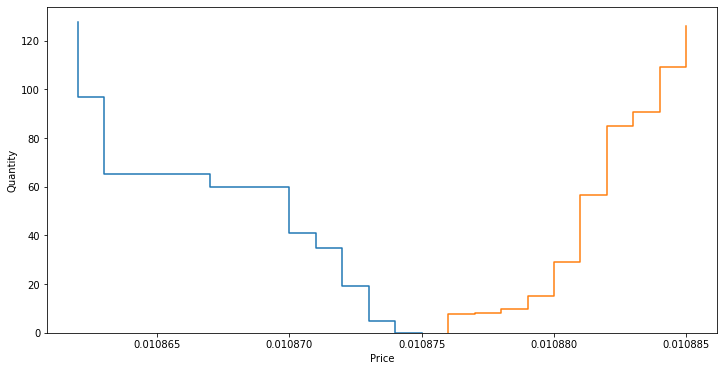

In [11]:
symbol='bnbbtc'
depth=10
refresh_rate=0.5
total_time=1
dfs = []
for i in range(total_time*60):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(12,6))
    book = OrderBook(symbol)
    dfs.append(create_dataframe().iloc[:depth, :])
    sns.ecdfplot(x="bids", weights="bq", stat="count", complementary=True, data=dfs[-1], ax=ax)
    sns.ecdfplot(x="asks", weights="aq", stat="count", data=dfs[-1], ax=ax)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.6f}'.format(x)))
    ax.set_xlabel("Price")
    ax.set_ylabel("Quantity")

    plt.show()
    dfs.pop(0)
    time.sleep(refresh_rate)